# PAFER implementation
This is an implementation of the Privacy Aware Fairness Estimation of Rules (PAFER) method as described in my thesis (proposal). The goal of the method is to predict the Statistical Parity of a decision tree, whilst adhering to some privacy constraint. This specific notebook implements the Gaussian, Laplacian and Exponential differential privacy mechanism, and tests them on the Adult dataset. First, the data is imported and pre-processed, then the decision tree is trained, followed by the implementation of PAFER and some experiments of the different mechanisms. The notebook is developed in Python 3.11 for performance reasons. A ```requirements.txt``` file is available. 

## Imports

In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import ttest_ind
from tqdm import tqdm

## Data loading and pre-processing

In [2]:
# The Adult data source: https://archive.ics.uci.edu/ml/datasets/adult
adult_train = pd.read_csv("adult.data", sep=',\s+', engine='python')
adult_test = pd.read_csv("adult.test", sep=',\s+', engine='python')

In [3]:
adult_test

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,outcome
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [4]:
# drop incomplete instances, rows that contain ? values
adult_test = adult_test[(adult_test != '?').all(1)]
adult_train = adult_train[(adult_train != '?').all(1)]

# drop fnlwgt column, which is uninformational and might cause overfitting
adult_test = adult_test.drop(columns=["fnlwgt"])
adult_train = adult_train.drop(columns=["fnlwgt"])

In [5]:
# separate labels
adult_test_y = adult_test['outcome']
adult_test_X = adult_test.loc[:, adult_test.columns != 'outcome']
adult_train_y = adult_train['outcome']
adult_train_X = adult_train.loc[:, adult_train.columns != 'outcome']

In [6]:
# transform labels to 0 and 1, above 50k is favorable outcome
adult_test_y = adult_test_y.map({'<=50K.': 0, '>50K.': 1})
adult_train_y = adult_train_y.map({'<=50K': 0, '>50K': 1})

In [7]:
# remove race and sex from model data
adult_train_sex = adult_train_X["sex"]
adult_test_sex = adult_test_X["sex"]
adult_train_race = adult_train_X["race"]
adult_test_race = adult_test_X["race"]
adult_train_nc = adult_train_X["native-country"]
adult_test_nc = adult_test_X["native-country"]
adult_train_X = adult_train_X.drop(columns=["race", "sex", "native-country"])
adult_test_X = adult_test_X.drop(columns=["race", "sex", "native-country"])

In [8]:
# convert race data to binary white - non-white
race_map_dict = {"White": "White", "Black": "Non_White", "Asian-Pac-Islander": "Non_White", "Other": "Non_White", "Amer-Indian-Eskimo": "Non_White"}
adult_train_race = adult_train_race.map(race_map_dict)
adult_test_race = adult_test_race.map(race_map_dict)
adult_train_race.value_counts()

White        25933
Non_White     4229
Name: race, dtype: int64

In [9]:
# convert the two sensitive attributes into a dataframe and then into a series
adult_train_sexrace = pd.concat([adult_train_sex, adult_train_race], axis=1)
adult_train_sex_race = adult_train_sexrace[['sex', 'race']].agg('-'.join, axis=1)
adult_train_sex_race.value_counts()

Male-White          18038
Female-White         7895
Male-Non_White       2342
Female-Non_White     1887
dtype: int64

In [10]:
# convert both datasets to one-hot encoding
adult_train_cat_X = pd.get_dummies(adult_train_X)
adult_test_cat_X = pd.get_dummies(adult_test_X)

## Tree construction and evaluation 

In [11]:
# construct decision tree
tree = DecisionTreeClassifier(random_state=42)

parameter_grid={"criterion":["entropy"], "max_depth":[2, 3, 4], 
                "max_features":["sqrt", None, "log2"], 
                "max_leaf_nodes":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
tree_cv = GridSearchCV(tree, param_grid=parameter_grid, scoring='balanced_accuracy', n_jobs=2, cv=3, verbose=2)
tree_cv.fit(adult_train_cat_X, adult_train_y)
best_tree = tree_cv.best_estimator_
best_tree

Fitting 3 folds for each of 90 candidates, totalling 270 fits


DecisionTreeClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=5,
                       random_state=42)

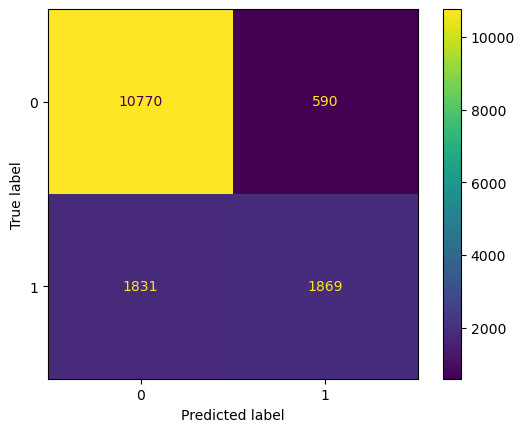

In [12]:
# confusion matrix / performance on testset
y_pred = best_tree.predict(adult_test_cat_X)
cm = confusion_matrix(adult_test_y, y_pred, labels=best_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_tree.classes_)
disp.plot()

In [13]:
print(f"Balanced accuracy on test set: {balanced_accuracy_score(adult_test_y, y_pred)}")
print(f"ROC-AUC score on test set: {roc_auc_score(adult_test_y, y_pred)}")
print(f"Accuracy score: {accuracy_score(adult_test_y, y_pred)}")

Balanced accuracy on test set: 0.7265992577084126
ROC-AUC score on test set: 0.7265992577084127
Accuracy score: 0.8392430278884462


In [14]:
column_names = [name for name in adult_train_cat_X.columns]
print(export_text(best_tree, feature_names=column_names))

|--- marital-status_Married-civ-spouse <= 0.50
|   |--- capital-gain <= 7073.50
|   |   |--- class: 0
|   |--- capital-gain >  7073.50
|   |   |--- class: 1
|--- marital-status_Married-civ-spouse >  0.50
|   |--- education-num <= 12.50
|   |   |--- capital-gain <= 5095.50
|   |   |   |--- class: 0
|   |   |--- capital-gain >  5095.50
|   |   |   |--- class: 1
|   |--- education-num >  12.50
|   |   |--- class: 1



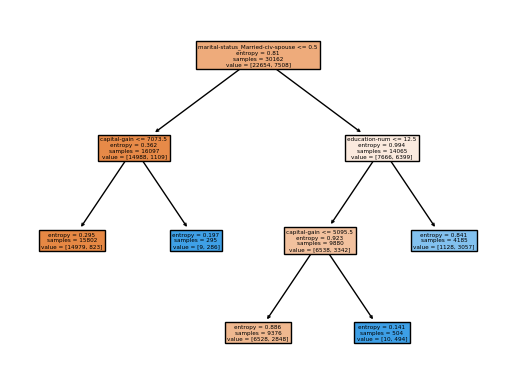

In [15]:
plot_tree(best_tree, feature_names=adult_train_cat_X.columns, filled=True)
plt.savefig("adulttree.png", dpi=800)
plt.show()

## Rule extraction

In [16]:
# taken from: https://stackoverflow.com/questions/56334210/how-to-extract-sklearn-decision-tree-rules-to-pandas-boolean-conditions
n_nodes = best_tree.tree_.node_count
children_left = best_tree.tree_.children_left
children_right = best_tree.tree_.children_right
feature = best_tree.tree_.feature
threshold = best_tree.tree_.threshold

def find_path(node_numb, path, x):
    path.append(node_numb)
    if node_numb == x:
        return True
    left = False
    right = False
    if (children_left[node_numb] !=-1):
        left = find_path(children_left[node_numb], path, x)
    if (children_right[node_numb] !=-1):
        right = find_path(children_right[node_numb], path, x)
    if left or right :
        return True
    path.remove(node_numb)
    return False


def get_rule(df_name, path, column_names):
    mask = ''
    for index, node in enumerate(path):
        # check if we are not in the leaf
        if index!=len(path)-1:
            # under or over the threshold?
            if (children_left[node] == path[index+1]):
                mask += f"{df_name}['{column_names[feature[node]]}']<= {threshold[node]} \t "
            else:
                mask += f"{df_name}['{column_names[feature[node]]}']> {threshold[node]} \t "
                
    # insert the & at the right places
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask

In [17]:
# Leaves
leave_id = best_tree.apply(adult_train_cat_X)

paths = {}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

rules = {}
for key in paths:
    rules[key] = get_rule("adult_train_cat_X", paths[key], column_names)
    
rules

{4: "adult_train_cat_X['marital-status_Married-civ-spouse']> 0.5 & adult_train_cat_X['education-num']> 12.5  ",
 5: "adult_train_cat_X['marital-status_Married-civ-spouse']<= 0.5 & adult_train_cat_X['capital-gain']<= 7073.5  ",
 6: "adult_train_cat_X['marital-status_Married-civ-spouse']<= 0.5 & adult_train_cat_X['capital-gain']> 7073.5  ",
 7: "adult_train_cat_X['marital-status_Married-civ-spouse']> 0.5 & adult_train_cat_X['education-num']<= 12.5 & adult_train_cat_X['capital-gain']<= 5095.5  ",
 8: "adult_train_cat_X['marital-status_Married-civ-spouse']> 0.5 & adult_train_cat_X['education-num']<= 12.5 & adult_train_cat_X['capital-gain']> 5095.5  "}

## PAFER (Privacy Aware Fairness Estimation of Rules)

In [18]:
def positive_rules(rules):
    """From the extracted rules, return those that have a favorable classification
    
    Arg:
        rules: dict of which the values are rule strings
        
    Returns:
        A list of all the rules that classify favorably"""
    
    # positive rules are those that end in > X
    return [rules[rule] for rule in rules if '>' in rules[rule].split('&')[-1]]


def oracle(dataset, sens_dataset, rule, s_i, mechanism=None, epsilon=0.05, delta=0.001):
    """Returns some (differentially privatised) statistics on the sensitive attribute for the specified dataframe and rule
    
    Args:
        df: The DataFrame that the developers own, which does not contain sensitive attributes.
            Used to calculate total quantities in (root) nodes.
        sens_dataset: A Series that the developers do not own, which contains the sensitive attributes. 
            Combined sensitive attributes should be encoded as a Series, e.g. Black-Female
        rule: The rule, as a string, for which the to estimate the sensitive attribute.
        s_i: The sensitive attribute, its name comes from the ith element in the set S of sensitive attributes.
            s_i should be in sens_dataset and should thus be a string. 
        mechanism: The privacy mechanism used on the returned counts. Can be one of "gaussian", "laplacian", "exponential", None. 
        epsilon: The privacy budget. Should be larger than 0.
        delta: The privacy margin. Ignored when mechanism is either laplacian or gaussian. Should be in (0, 1]. 
        
    Returns:
        The number of times s_i occurs in sens_dataset, privatised via the mechanism. 
        """
        
    # check epsilon and delta parameters
    if epsilon <= 0 or (mechanism == "gaussian" and (delta <= 0 or delta > 1 or epsilon > 1)):
        raise ValueError("The value of delta should be in (0,1] when using the gaussian mechanism")
    
    if not sens_dataset.isin([s_i]).any():
        raise KeyError("The requested sensitive attribute (s_i) is not in the sensitive dataframe (sens_dataset)")
        
    # the answer if no privacy mechanism is applied
    no_mechanism = sens_dataset.loc[dataset[pd.eval(rule)].index].value_counts(sort=False)[s_i]
    
    if mechanism == "laplacian":
        # this is a histogram query so the l1-sensitivity = 1 as per Dwork & Roth 
        sensitivity = 1
        return no_mechanism + np.random.laplace(loc=0, scale=sensitivity / epsilon)
    
    elif mechanism == "gaussian":
        # this is a histogram query so the l2-sensitivity = 2 as per Dwork & Roth
        sensitivity = 2
        return no_mechanism + np.random.normal(loc=0, scale=2 * sensitivity**2 * np.log(1.25 / delta) / epsilon**2)
    
    elif mechanism == "exponential":
        # this query can only change by 1 if an instance is omitted so l1-sensitivity = 1
        sensitivity = 1
        
        # np.arange is [start, stop) so + 1 for entire possible range
        possible_values = np.arange(0, sens_dataset.loc[dataset[pd.eval(rule)].index].value_counts().to_numpy().sum() + 1)
        
        # the utility is higher when the value is closer to the actual value
        utility_scores = np.array([no_mechanism - abs(no_mechanism - value) for value in possible_values]) / 100
        probabilities = [np.exp(epsilon * score / (2 * sensitivity)) for score in utility_scores]
        
        # normalize probabilties to sum to 1
        probabilities /= np.linalg.norm(probabilities, ord=1)
        return np.random.choice(possible_values, p=probabilities)

    # if no mechanism is given, return the unprivatised cocunt
    return no_mechanism

oracle(adult_train_cat_X, adult_train_sex, rules[4], "Male", "exponential", epsilon=1, delta=0.1)

3753

In [22]:
def statistical_parity(y_pred, sens_dataset):
    """Calculates Statistical Parity Ratio using the predictions and the actual sensitive feature values
    
    Args:
        y_pred: The predictions, should be of same size as sens_dataset.
        sens_dataset: The Series with the sensitive attributes.
        
    Returns:
        The true statistical parity ratio.
        """
    accept_rates = []
    
    for sens_attr in sens_dataset.value_counts().keys():
        accept_rates.append(np.sum((sens_dataset == sens_attr) & y_pred) / np.sum(sens_dataset == sens_attr))
        
    return min(accept_rates) / max(accept_rates)


def estimate_sp(pos_ruleset, dataset, sens_dataset, S, mechanism, epsilon, delta):
    """Returns the estimated Statistical Parity of a tree for a privacy mechanism
    
    Args:
        pos_ruleset: A list of rules that classify favorably in the tree. This is the representation of the
        (relevant parts of the) tree. 
        dataset: The DataFrame that the developers own that does not contain sensitive feature values.
        sens_dataset: The Series that contains the sensitive features, which the developers do not own.
        S: The set/list of sensitive attributes, should all be in the sens_dataset attribute.
        mechanism: The mechanism with which to privatise the queries. 
        epsilon: The privacy budget for the privacy mechanism. Should be larger than 0.
        delta: The privacy margin. Ignored when mechanism is either laplacian or gaussian. Should be in (0, 1].
        
    Returns:
        The statistical parity ratio for the specified pos_ruleset. 
        """
    
    poscounts_per_si = np.zeros(len(S))
    
    # the base rule is a rule that includes all individuals, everyone is either 0 or older
    base_rule = f"{pos_ruleset[0].split('[')[0]}['age'] >= 0"
    
    # we can calculate the last count ourselves so we iterate one less
    total_per_si = [oracle(dataset, sens_dataset, base_rule, s_i, mechanism, epsilon, delta) for s_i in S[:-1]]
    total_per_si.append(len(sens_dataset) - sum(total_per_si))
    
    for rule in pos_ruleset:
        # for each rule we find the distribution of sensitive attributes
        rule_counts = np.zeros(len(S))
        rule_total = len(sens_dataset[pd.eval(rule)])
        
        # we can calculate the last count ourselves so we iterate one less
        for i, s_i in enumerate(S[:-1]):
            # because the queries are disjoint, epsilon remains equal across queries
            rule_counts[i] += round(oracle(dataset, sens_dataset, rule, s_i, mechanism, epsilon, delta))
            
        rule_counts[-1] += rule_total - np.sum(rule_counts[:-1])
        
        # the distribution for the current rule is added to the total
        poscounts_per_si += rule_counts
    
    # calculate and return sp
    return np.min(poscounts_per_si / total_per_si) / np.max(poscounts_per_si / total_per_si)


## PAFER experiments

In [23]:
def experiment(ruleset, rule_pred, dataset, sens_dataset, epsilon, 
               delta=0.0001, mechanisms=["exponential", "gaussian", "laplacian"], runs=10):
    """Compares average Statistical Parity Error for different mechanisms
    
    Args:
        ruleset: The rules that represent a rule based decision system.
        rule_pred: The predictions that the ruleset has made for the dataset.
        dataset: The DataFrame that the developers own that does not contain sensitive feature values.
        sens_dataset: The Series that contains the sensitive features, which the developers do not own.
        epsilon: The privacy budget for the privacy mechanism. Should be larger than 0.
        delta: The privacy margin. Ignored when mechanism is either laplacian or gaussian. Should be in (0, 1].
        mechanisms: The list of mechanisms you want to compare. 
            Should be a subset of {"exponential", "gaussian", "laplacian", "None"}.
        runs: The number of times to perform the experiment, fewer runs will result in less reliable outcomes. 
        
    Returns:
        A numpy array that contains the absolute difference between the actual sp and the estimated sp. 
    """
    
    pos_rules = positive_rules(ruleset)
    actual_sp = statistical_parity(rule_pred, sens_dataset)
    errors = np.zeros((runs, len(mechanisms)))
    S = sens_dataset.value_counts(sort=False).index
    
    for row in range(runs):
        for col, mechanism in enumerate(mechanisms):
            errors[row, col] = abs(estimate_sp(pos_rules, dataset, sens_dataset, S, mechanism, epsilon, delta) - actual_sp)
            
    return errors


In [24]:
epsilons = np.linspace(0.01, 1, 45)
runs = 2

laplace_errs, exp_errs = [], []
laplace_uncert, exp_uncert = [], []
for epsilon in tqdm(epsilons):
    sp_errs = experiment(rules, best_tree.predict(adult_train_cat_X), adult_train_cat_X,
                         adult_train_sex, epsilon=epsilon, runs=runs, mechanisms=["laplacian", "exponential"])
    
    avg_errs = np.mean(sp_errs, axis=0)
    std_errs = np.std(sp_errs, ddof=1, axis=0)
    uncertainty = std_errs / np.sqrt(runs)
    
    laplace_errs.append(avg_errs[0])
    exp_errs.append(avg_errs[1])
    laplace_uncert.append(uncertainty[0])
    exp_uncert.append(uncertainty[1])
    

100%|█████████████████████████████████████████████████████████████████| 45/45 [03:31<00:00,  4.70s/it]


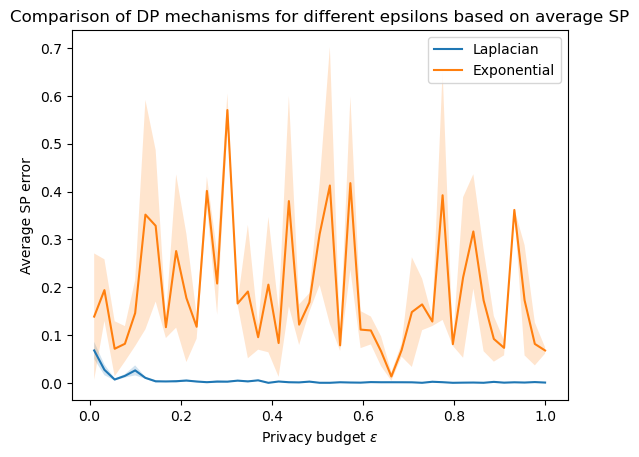

In [26]:
# convert to numpy arrays
laplace_errs = np.array(laplace_errs)
exp_errs = np.array(exp_errs)
laplace_uncert = np.array(laplace_uncert)
exp_uncert = np.array(exp_uncert)

plt.plot(epsilons, laplace_errs, label="Laplacian")
plt.fill_between(epsilons, laplace_errs + laplace_uncert, laplace_errs + laplace_uncert * -1, alpha=0.2)
plt.plot(epsilons, exp_errs, label="Exponential")
plt.fill_between(epsilons, exp_errs + exp_uncert, exp_errs + exp_uncert * -1, alpha=0.2)
plt.legend()
plt.title("Comparison of DP mechanisms for different epsilons based on average SP")
plt.ylabel("Average SP error")
plt.xlabel("Privacy budget $\epsilon$")
plt.savefig(f"adult-sex-mechcomp-runs={runs}.png", dpi=800)
plt.show()
